# Input-output hidden Markov model

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks', font_scale=1.5)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

np.random.seed(363)

In [2]:
# generate dataset
num_samples = 600
num_factors = 3
coefs = np.array([[-2, 0], [2, 6], [2, -5]])
p_tr = np.array([[0.9, 0.05, 0.05], [0.01, 0.98, 0.01], [0.03, 0.02, 0.95]])

features = np.random.uniform(-5, 5, num_samples)
features = np.vstack([features, np.ones(num_samples)]).T

observations = np.zeros(num_samples)
labels = np.zeros(num_samples, dtype=int)

s = 0
for i, feat in enumerate(features):
    observations[i] = np.floor(1 / (1 + np.exp(-feat @ coefs[s])) + 0.5)
    labels[i] = s
    s = np.random.choice(num_factors, p=p_tr[s])

In [3]:
### problem data
xs = features  # ndarray: dataset features
ys = observations  # ndarray: dataset observations
m = xs.shape[0]  # int: number of samples in the dataset
n = xs.shape[-1]

### hyperparameters
eps = 1e-6  # float: termination criterion

### P-problem
K = 3
lbd_theta = 1.8  # regularization weight
thetas = []  # list of cp.Variable objects: model parameters
r = []  # list of cp.Expression objects: loss functions
for k in range(K):
    thetas.append(cp.Variable(n))
    r.append(-(cp.multiply(ys, xs @ thetas[-1]) - cp.logistic(xs @ thetas[-1])))

ztil = cp.Parameter((m, K), nonneg=True)
Pobj = cp.sum(cp.diag(ztil @ cp.vstack(r)))
Preg = lbd_theta * cp.sum(cp.norm2(cp.vstack(thetas), axis=1))  # cp.Expression: regularization on model parameters
Pconstr = [
    thetas[0][0] <= 0,
    thetas[1][0] >= 0,
    thetas[2][0] >= 0,
]  # list of cp.Constraint objects: model parameter constraints
Pprob = cp.Problem(cp.Minimize(Pobj + Preg), Pconstr)
assert Pprob.is_dcp()

### F-problem
lbd_z = 1.5  # regularization weight
rtil = cp.Parameter((K, m))
z = cp.Variable((m, K))
Fobj = cp.sum(cp.diag(z @ rtil))
Freg = lbd_z * cp.sum(cp.kl_div(z[:-1], z[1:]))  # cp.Expression: regularization on latent factors
Fconstr = [z >= 0, z <= 1, cp.sum(z, axis=1) == 1]
Fprob = cp.Problem(cp.Minimize(Fobj + Freg), Fconstr)
assert Fprob.is_dcp()

### solve, terminate when the F- and P-objective converge
i = 0
while True:
    i += 1
    if ztil.value is None:
        ztil.value = np.random.dirichlet(np.ones(K), size=m)
    else:
        ztil.value = np.abs(z.value)
    Pprob.solve()

    rtil.value = cp.vstack(r).value
    Fprob.solve()

    print(f"Iteration {i}: P-problem value: {Pobj.value}, F-problem value: {Fobj.value}, gap: {np.abs(Pobj.value - Fobj.value)}.")
    if np.abs(Pobj.value - Fobj.value) < eps:
        break

Iteration 1: P-problem value: 384.411576305228, F-problem value: 338.4039071729983, gap: 46.007669132229694.
Iteration 2: P-problem value: 186.25948421299722, F-problem value: 125.65182964677922, gap: 60.607654566218.
Iteration 3: P-problem value: 94.80338948823754, F-problem value: 79.33444724116504, gap: 15.468942247072505.
Iteration 4: P-problem value: 75.06910256152733, F-problem value: 69.70561518546302, gap: 5.363487376064313.
Iteration 5: P-problem value: 68.82280147389508, F-problem value: 66.41567051276749, gap: 2.407130961127592.
Iteration 6: P-problem value: 66.15913671949062, F-problem value: 64.96876134493134, gap: 1.1903753745592809.
Iteration 7: P-problem value: 64.87462464071639, F-problem value: 64.26714760788933, gap: 0.6074770328270631.
Iteration 8: P-problem value: 64.22789547022252, F-problem value: 63.913943713180686, gap: 0.31395175704183487.
Iteration 9: P-problem value: 63.896310747256386, F-problem value: 63.732900951316566, gap: 0.1634097959398204.
Iteration 

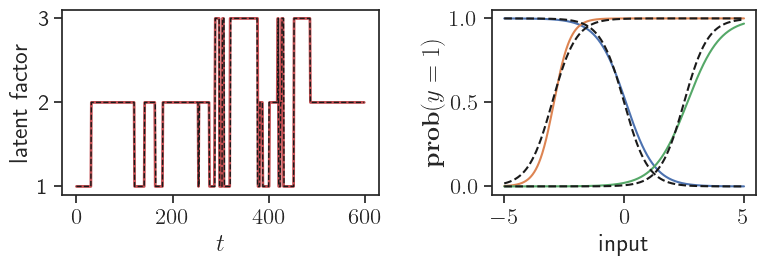

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), width_ratios=(1.2, 1))

axs[0].plot(labels, linestyle='dashed', color='k', linewidth=1, zorder=10)
axs[0].plot(np.argmax(z.value, axis=-1), color='r', linewidth=2)

inputs = np.linspace(-5, 5, m)
inputs = np.vstack([inputs, np.ones(m)]).T
for i in range(K):
    axs[1].plot(inputs[:, 0], 1 / (1 + np.exp(-inputs @ coefs[i])),
                linestyle='dashed', color='k', zorder=10)
    axs[1].plot(inputs[:, 0], 1 / (1 + np.exp(-inputs @ thetas[i].value)))

axs[0].set_xlabel('$t$')
axs[0].set_ylabel('latent factor')
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels([1, 2, 3])

axs[1].set_xlabel('input')
axs[1].set_ylabel(r'$\mathop{\bf prob}(y = 1)$')

plt.tight_layout()
fig.savefig('../figures/io_hmm.pdf', bbox_inches='tight')

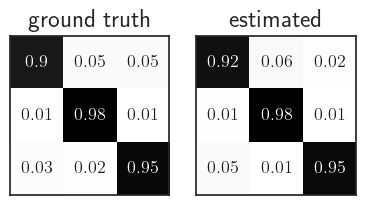

In [5]:
p_tr_hat = np.zeros_like(p_tr)
z_hat = np.argmax(z.value, axis=-1)
for zi in range(K):
    z_idx = np.where(z_hat == zi)[0]
    z_idx = np.delete(z_idx, np.where(z_idx == m - 1)[0])
    _, nz_num = np.unique(z_hat[z_idx + 1], return_counts=True)
    p_tr_hat[zi] = nz_num / len(z_idx)
    
fig, axs = plt.subplots(1, 2, figsize=(4, 3))

for c_idx, pmat in enumerate([p_tr, p_tr_hat]):
    axs[c_idx].imshow(pmat, cmap='Greys')
    for r in range(K):
        for c in range(K):
            color = 'k' if pmat[r, c] < 0.5 else 'white'
            axs[c_idx].text(c, r, f'${np.around(pmat[r, c], 2)}$', 
                        horizontalalignment='center', verticalalignment='center',
                        color=color, fontsize=13)
    axs[c_idx].set_xticks([])
    axs[c_idx].set_yticks([])

axs[0].set_title('ground truth')
axs[1].set_title('estimated')

plt.tight_layout()
fig.savefig('../figures/io_hmm_ptr.pdf', bbox_inches='tight')